In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow import keras

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [5]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [6]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Include test data and Models

In [7]:
test_datafile_fw = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_fw1_F11.h5'
test_datafile_iv = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1_F11.h5'



In [8]:
model_name_fw = 'forward_model/surrogate_model'
model_name_iv = 'forward_model/surrogate_model'

In [9]:
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw1_F11_small/models'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_iv1_F11_small/models'


In [10]:
# Resulting plots will be stored in the fw model directory
plot_dir = model_dir_fw +'/plots/model_1'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw1_F11_small/models/plots/model_1'

# Load the model and the data

In [11]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)


In [12]:
dvar_test = pd.read_hdf(test_datafile_iv,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile_iv,key = 'qoi')

# I just include the test_datafile_iv, because it should be the same as test_datafile_fw, just dvar and qoi are switched
# In the test datafile dvar are preprocessed already with:
# log(dvar['Vtot'],dvar['RmedianV'],dvar['GSD']-1, dvar['n']-1.33,dvar['k'])
# qoi are preprocessed with log(qoi[F11])

dvar_test_preprocessed = dvar_test.copy()
qoi_test_preprocessed = qoi_test.copy()


In [13]:
#dvar_test1 = pd.read_hdf(test_datafile_fw,key = 'dvar')
#qoi_test1 = pd.read_hdf(test_datafile_fw,key = 'qoi')


# Predict aerosol properties from phase functions

In [14]:
dvar_pred = surr_fw.predict(qoi_test_preprocessed)
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)

In [15]:
dvar_pred = np.exp(dvar_pred)
dvar_pred['GSD']=dvar_pred['GSD']+1
dvar_pred['n']= dvar_pred['n']+1.33

dvar_test = np.exp(dvar_test)
dvar_test['GSD']=dvar_test['GSD']+1
dvar_test['n']=dvar_test['n']+1.33

## 1.calculate metrics

In [16]:
fw_error_df = pd.DataFrame(columns = dvar_test.columns)
fw_error_df


Empty DataFrame
Columns: [Vtot, RmedianV, GSD, n, k]
Index: []

In [17]:
# R2 value
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_fw = metric.call(dvar_test.values, dvar_pred.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=dvar_test.columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
r2_adj_fw

Vtot  RmedianV   GSD     n    k
0  0.97      0.96  0.98  0.69  0.9

In [18]:
fw_error_df.loc['r2']= [r2_adj_fw['Vtot'].values[0], r2_adj_fw['RmedianV'].values[0],r2_adj_fw['GSD'].values[0],r2_adj_fw['n'].values[0],r2_adj_fw['k'].values[0]]
fw_error_df


Vtot  RmedianV   GSD     n    k
r2  0.97      0.96  0.98  0.69  0.9

In [19]:
# absolute error
abs_error_fw = np.abs(dvar_test-dvar_pred)
abs_error_fw = pd.DataFrame(abs_error_fw, columns=dvar_test.columns).abs()
abs_error_fw.reset_index(drop=True, inplace=True)
abs_error_fw

Vtot    RmedianV       GSD         n         k
0        0.217794    1.961295  0.000142  0.381713  0.198211
1        1.377629  317.651950  0.104686  0.039288  0.077230
2        5.049560    0.509203  0.003009  0.538121  0.172510
3        0.341656    7.966712  0.010675  0.257649  0.125845
4       54.467437    7.100668  0.097897  0.569784  0.024963
...           ...         ...       ...       ...       ...
19464   31.782509    1.396360  0.033086  0.003212  0.005193
19465    0.006959    3.730325  0.010102  0.025077  0.119318
19466    0.435902   16.497680  0.006054  0.788183  0.118769
19467  115.931608   36.000456  0.010590  0.160132  0.144420
19468    5.916810    0.746698  0.022580  0.036875  0.040192

[19469 rows x 5 columns]

In [20]:
abs_error_table_fw = np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

Vtot  RmedianV   GSD     n     k
50%    3.86     17.83  0.03  0.11  0.07
75%   38.28     96.16  0.07  0.24  0.17
90%  170.32    366.53  0.13  0.45  0.33
95%  319.15    608.58  0.17  0.60  0.44
99%  819.72   1039.25  0.28  0.87  0.70

In [21]:
fw_error_df.loc['abs error 90%'] = abs_error_table_fw.loc['90%']

fw_error_df.loc['abs error 95%'] = abs_error_table_fw.loc['95%']


In [22]:
rel_error_fw = np.abs(dvar_test - dvar_pred) / dvar_test * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=dvar_test.columns).abs()
rel_error_fw.reset_index(drop=True, inplace=True)
rel_error_fw

Vtot   RmedianV       GSD          n          k
0       4.397182   0.438671  0.008394  14.553701  26.280829
1      13.981074  10.756519  3.972321   1.881637   4.320778
2      18.229452   0.200011  0.288204  18.468676  15.665718
3       0.697093   1.533693  0.488412  10.898638   6.121831
4      12.338939   7.067373  4.439275  19.759268   1.258600
...          ...        ...       ...        ...        ...
19464   1.094858   0.570365  1.614926   0.220127   1.107885
19465   0.183459   1.825474  0.837308   1.605416  11.029198
19466   4.848373   3.124098  0.310530  29.306519   6.337796
19467   4.897697   4.614900  0.414370   5.705126  26.840067
19468   7.010301   0.442795  0.875233   1.438534   3.640275

[19469 rows x 5 columns]

In [23]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

Vtot  RmedianV    GSD      n       k
50%   6.43      3.62   1.62   5.24    7.65
75%  11.15      7.13   3.10  10.64   19.09
90%  19.79     13.88   5.62  18.83   38.85
95%  27.16     19.65   7.92  24.90   67.77
99%  45.83     31.93  15.05  35.36  269.46

In [24]:
fw_error_df.loc['rel error 90%'] = rel_error_table_fw.loc['90%']

fw_error_df.loc['rel error 95%'] = rel_error_table_fw.loc['95%']
                                            

In [25]:
wMAPE_fw = wmape(dvar_test, dvar_pred)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T
wMAPE_fw=np.round(wMAPE_fw, decimals =2)
wMAPE_fw

Vtot  RmedianV   GSD     n      k
0  10.4      9.06  2.57  8.29  11.52

In [26]:
fw_error_df.loc['wmape'] = [wMAPE_fw['Vtot'].values[0],wMAPE_fw['RmedianV'].values[0],wMAPE_fw['GSD'].values[0],wMAPE_fw['n'].values[0],wMAPE_fw['k'].values[0]]
fw_error_df

Vtot  RmedianV   GSD      n      k
r2               0.97      0.96  0.98   0.69   0.90
abs error 90%  170.32    366.53  0.13   0.45   0.33
abs error 95%  319.15    608.58  0.17   0.60   0.44
rel error 90%   19.79     13.88  5.62  18.83  38.85
rel error 95%   27.16     19.65  7.92  24.90  67.77
wmape           10.40      9.06  2.57   8.29  11.52

In [27]:
fw_error_df.to_csv(f'{plot_dir}/fw_error_df.csv')

## 2. plots

In [28]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [29]:
dvar_test['DmedianV']=dvar_test['RmedianV']*2*1e-3 #[um]
dvar_test['DmedianN']=(np.exp(np.log(dvar_test['DmedianV']) - (3*np.log(dvar_test['GSD'])**2))) *1e3   #[nm]
dvar_test['Ntot'] = 6 / np.pi * dvar_test['Vtot']*1e9 / (np.exp((3*np.log(dvar_test['DmedianN'])) + (4.5*np.log(dvar_test['GSD'])**2))) # [cm^-3]
 

In [30]:
dvar_pred['DmedianV']=dvar_pred['RmedianV']*2*1e-3 #[um]
dvar_pred['DmedianN']=(np.exp(np.log(dvar_pred['DmedianV']) - (3*np.log(dvar_pred['GSD'])**2))) *1e3   #[nm]
dvar_pred['Ntot'] = 6 / np.pi * dvar_pred['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred['DmedianN'])) + (4.5*np.log(dvar_pred['GSD'])**2))) # [cm^-3]


In [31]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

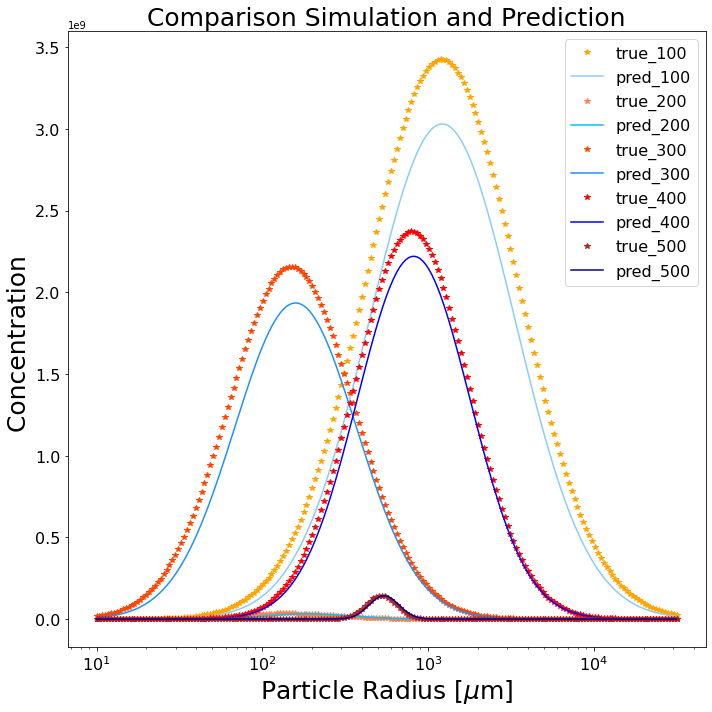

In [32]:
fig, ax = plt.subplots(figsize = (10,10))

colors_blue = ['lightskyblue','deepskyblue','dodgerblue','blue','darkblue']
colors_red = ['orange','coral','orangered','red','firebrick','darkred']

j = 0
for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test['DmedianN'].loc[i], dvar_test['GSD'].loc[i], dvar_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred['DmedianN'].loc[i], dvar_pred['GSD'].loc[i], dvar_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*', color = colors_red[j], label = 'true_'+str(i))
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., color = colors_blue[j], label = 'pred_'+str(i))
    


    ax.legend(fontsize = 16)   
    j = j+1
ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')

## 3. plot the biggest error 

In [33]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [34]:
testGSD1 = rel_error_fw['GSD'].values
testR = rel_error_fw['RmedianV'].values
testn = rel_error_fw['n'].values
testk = rel_error_fw['k'].values
testVtot = rel_error_fw['Vtot'].values
testGSD2 = np.log(dvar_test['RmedianV'].values)
testGSD3 = np.log(dvar_test['GSD'].values)


In [35]:
grid_x, grid_y = np.mgrid[100:5001:1, 1.01:3.1:0.01]

grid_x = np.log(grid_x)
grid_y = np.log(grid_y)
grid_GSD = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='nearest')
grid_R = griddata((testGSD2,testGSD3), testR, (grid_x, grid_y), method='nearest')
grid_Vtot = griddata((testGSD2,testGSD3), testVtot, (grid_x, grid_y), method='nearest')
grid_n = griddata((testGSD2,testGSD3), testn, (grid_x, grid_y), method='nearest')
grid_k = griddata((testGSD2,testGSD3), testk, (grid_x, grid_y), method='nearest')


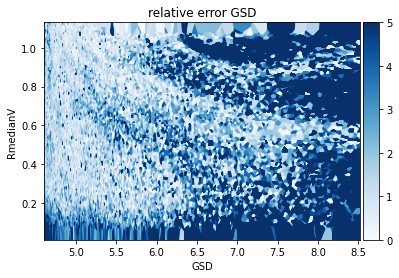

In [36]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_GSD.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error GSD')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errGSD_GSD_R.jpg')

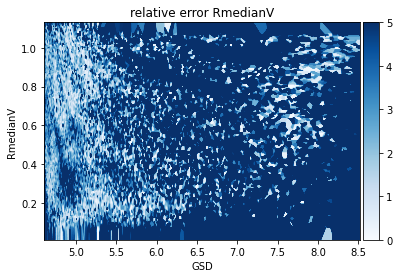

In [37]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_R.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error RmedianV')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errR_GSD_R.jpg')

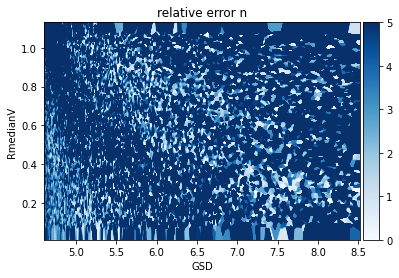

In [38]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_n.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error n')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errn_GSD_R.jpg')

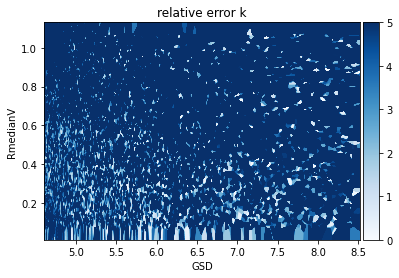

In [39]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_k.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error k')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errk_GSD_R.jpg')

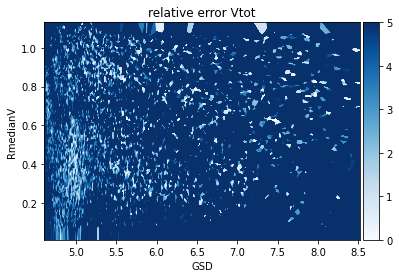

In [40]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_Vtot.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error Vtot')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errVtot_GSD_R.jpg')

# Predict phase functions from aerosol properties

In [41]:
qoi_pred = surr_iv.predict(dvar_test_preprocessed)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [42]:
F11_columns = [x for x in qoi_test.columns if 'F11' in x]
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

In [43]:
qoi_test[F11_columns] = np.exp(qoi_test[F11_columns])
qoi_pred[F11_columns] = np.exp(qoi_pred[F11_columns])


In [44]:
## 1. calculate metrics

In [45]:
metric = RSquaredSeparated()
r2_adj_iv = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=qoi_test.columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Forward model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))
r2_adj_iv

Forward model:  R2_min =  1.0 ;  R2_max =  1.0


F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  F11_167  \
0     1.0  ...      1.0      1.0      1.0      1.0      1.0      1.0      1.0   

   F11_168  F11_169  F11_170  
0      1.0      1.0      1.0  

[1 rows x 152 columns]

In [46]:
iv_error_df = pd.DataFrame(columns = ['F11','PPF'])
iv_error_df.loc['r2']= [np.mean(r2_adj_iv[F11_columns].mean()),np.mean(r2_adj_iv[PPF_columns].mean())]
iv_error_df

F11  PPF
r2  1.0  NaN

In [47]:
r2_adj_iv.values

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])

In [48]:
abs_error_iv = np.abs(qoi_pred - qoi_test)
abs_error_iv

F11_10      F11_11      F11_12      F11_13      F11_14      F11_15  \
0        0.269145    0.197754    0.185011    0.104120    0.094032    0.114209   
1        0.081531    0.040427    0.024576    0.020747    0.017289    0.029249   
2        1.273433    1.515718    2.194200    3.272814    5.136652    4.933082   
3        1.780071    2.455387    2.460770    1.027980    0.636702    0.995832   
4       10.863592   11.532827   15.412993    6.460389    3.969464    5.234218   
...           ...         ...         ...         ...         ...         ...   
19464  508.803525  388.023795  322.586543  267.723425  144.579380  143.787347   
19465    0.078403    0.113910    0.082095    0.100553    0.138442    0.108375   
19466    1.979211    1.557374    1.131541    0.683438    0.389833    0.323163   
19467   47.263770    7.497079    1.046425   31.054261   68.518737   62.606111   
19468    1.675040    1.539379    1.039378    0.162416    1.084779    1.179956   

           F11_16     F11_17     F11_18     F11_19  ...   F11_161   F11_162  \
0        0.071369   0.035150   0.032954   0.037961  ...  0.000477  0.000520   
1        0.024169   0.016388   0.015424   0.007778  ...  0.000381  0.000226   
2        4.300979   3.709656   3.198166   2.568075  ...  0.258989  0.282632   
3        1.095910   0.916463   0.793341   0.342991  ...  0.002786  0.008870   
4        1.520317   3.745025   8.885926  11.795669  ...  7.101173  5.700783   
...           ...        ...        ...        ...  ...       ...       ...   
19464  107.722605  55.941299  26.371252  34.368222  ...  0.134005  0.254822   
19465    0.135198   0.157702   0.087981   0.091790  ...  0.009315  0.009784   
19466    0.236076   0.163612   0.128171   0.090526  ...  0.000960  0.001007   
19467   71.415217  67.595267  78.506989  74.693781  ...  1.552922  1.866750   
19468    1.631983   2.276317   2.125802   2.605928  ...  0.276365  0.282657   

        F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0      0.000279  0.000148  0.000722  0.000227  0.000813  0.000826  0.000032   
1      0.000078  0.000138  0.000350  0.000082  0.000689  0.000087  0.000271   
2      0.276971  0.294093  0.284480  0.290764  0.287590  0.305572  0.273512   
3      0.010405  0.010449  0.015117  0.027277  0.001029  0.030538  0.030301   
4      5.902200  4.521934  6.092741  6.042210  6.613374  5.814432  4.637758   
...         ...       ...       ...       ...       ...       ...       ...   
19464  0.286833  0.126939  0.061723  0.907009  0.157478  0.856874  1.229723   
19465  0.008904  0.008746  0.009841  0.009654  0.010358  0.011779  0.010905   
19466  0.000138  0.000103  0.000715  0.001217  0.000789  0.003118  0.002064   
19467  2.055295  2.209935  2.540307  2.761229  3.308008  3.291142  3.341773   
19468  0.215617  0.270803  0.250096  0.173659  0.325383  0.232395  0.154633   

        F11_170  
0      0.000109  
1      0.000046  
2      0.278229  
3      0.030505  
4      6.414605  
...         ...  
19464  1.222700  
19465  0.012310  
19466  0.001959  
19467  4.170009  
19468  0.240564  

[19469 rows x 152 columns]

In [49]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.76    1.36    1.11    0.89    0.70    0.62    0.55    0.50    0.43   
75%   16.28   13.08   11.20    8.63    6.90    5.84    5.06    4.83    4.37   
90%   76.30   62.00   55.89   43.44   33.43   29.74   26.19   25.83   26.09   
95%  157.52  133.03  119.03   89.88   73.51   64.23   58.97   59.45   60.07   
99%  456.97  383.31  326.76  279.18  231.33  213.73  196.22  198.84  195.42   

     F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  \
50%    0.38  ...     0.02     0.02     0.02     0.02     0.02     0.02   
75%    4.27  ...     0.21     0.21     0.22     0.22     0.23     0.24   
90%   27.67  ...     1.39     1.41     1.46     1.50     1.56     1.53   
95%   64.68  ...     3.89     3.81     3.96     4.01     4.20     4.12   
99%  202.68  ...    20.29    20.07    21.46    22.00    22.33    21.38   

     F11_167  F11_168  F11_169  F11_170  
50%     0.03     0.03     0.03     0.03  
75%     0.26     0.26     0.26     0.28  
90%     1.80     1.68     1.74     1.86  
95%     5.07     4.64     4.61     4.99  
99%    25.82    24.03    24.70    26.49  

[5 rows x 152 columns]

In [50]:
iv_error_df.loc['abs error 90%']=[abs_error_table_iv[F11_columns].loc['90%'].max(), abs_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['abs error 95%']=[abs_error_table_iv[F11_columns].loc['95%'].max(), abs_error_table_iv[PPF_columns].loc['95%'].max()]


In [51]:
rel_error_iv = abs_error_iv / qoi_test * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=qoi_test.columns).abs()
rel_error_iv

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      1.348890  1.081551  1.107150  0.683201  0.677635  0.905008  0.622380   
1      1.014581  0.624762  0.464960  0.474473  0.472560  0.945769  0.915944   
2      1.240148  1.509935  2.240779  3.433741  5.548695  5.498378  4.957124   
3      1.015060  1.555123  1.727530  0.798227  0.545658  0.939853  1.136542   
4      1.129664  1.223092  1.668637  0.714569  0.448897  0.605589  0.180061   
...         ...       ...       ...       ...       ...       ...       ...   
19464  6.483358  5.227874  4.601635  4.047796  2.318873  2.448060  1.947895   
19465  0.653129  0.965296  0.708838  0.886040  1.246929  0.999341  1.278340   
19466  5.925047  5.191548  4.197682  2.818731  1.785312  1.641037  1.327154   
19467  0.742463  0.133950  0.021151  0.706615  1.747180  1.781510  2.258968   
19468  0.710623  0.682804  0.482038  0.078753  0.549855  0.625109  0.903400   

         F11_17    F11_18    F11_19  ...    F11_161    F11_162    F11_163  \
0      0.337514  0.348493  0.442117  ...   0.238437   0.259167   0.139019   
1      0.721729  0.783255  0.452124  ...   0.345426   0.204425   0.070143   
2      4.430802  3.967118  3.315466  ...  16.588681  18.071254  17.662418   
3      1.042111  0.986985  0.465865  ...   0.071120   0.225958   0.264454   
4      0.454277  1.104440  1.502814  ...   3.527278   2.822331   2.912786   
...         ...       ...       ...  ...        ...        ...        ...   
19464  1.074779  0.538478  0.745983  ...   0.141387   0.268558   0.301941   
19465  1.531398  0.878795  0.944529  ...   3.611240   3.778501   3.425688   
19466  1.016530  0.878524  0.683267  ...   0.172797   0.180903   0.024725   
19467  2.368108  3.035832  3.177940  ...   1.675206   2.007638   2.203726   
19468  1.316283  1.283682  1.642749  ...   1.617803   1.649688   1.254758   

         F11_164    F11_165    F11_166    F11_167    F11_168    F11_169  \
0       0.073391   0.357992   0.112192   0.400719   0.406226   0.015700   
1       0.124421   0.316602   0.074414   0.622319   0.078744   0.244112   
2      18.690347  18.006618  18.321376  18.033388  19.063834  16.975695   
3       0.264956   0.382447   0.688438   0.025904   0.767106   0.759411   
4       2.224849   2.989057   2.956164   3.227274   2.830554   2.252671   
...          ...        ...        ...        ...        ...        ...   
19464   0.133466   0.064819   0.951344   0.164977   0.896624   1.285300   
19465   3.352595   3.758832   3.674499   3.929449   4.454404   4.111507   
19466   0.018447   0.127656   0.216842   0.140197   0.553027   0.365275   
19467   2.362427   2.707570   2.934526   3.505740   3.478417   3.522788   
19468   1.571469   1.447368   1.002396   1.873529   1.334982   0.886332   

         F11_170  
0       0.053393  
1       0.041475  
2      17.179944  
3       0.762800  
4       3.109291  
...          ...  
19464   1.276559  
19465   4.628363  
19466   0.346105  
19467   4.385127  
19468   1.376063  

[19469 rows x 152 columns]

In [52]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.77    1.59    1.51    1.34    1.21    1.19    1.17    1.19    1.18   
75%    3.18    2.79    2.63    2.39    2.23    2.22    2.20    2.19    2.15   
90%    5.10    4.54    4.14    3.82    3.65    3.68    3.70    3.62    3.43   
95%    6.88    6.18    5.66    5.25    4.92    4.91    5.21    5.08    4.77   
99%   18.50   16.67   15.79   14.72   11.20   10.07   12.21   13.39   12.47   

     F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  \
50%    1.19  ...     1.11     1.11     1.13     1.18     1.22     1.21   
75%    2.12  ...     2.14     2.15     2.18     2.24     2.30     2.29   
90%    3.33  ...     3.89     3.80     3.98     4.02     4.18     4.18   
95%    4.60  ...     5.85     5.91     6.10     6.23     6.37     6.44   
99%   10.87  ...    13.48    14.10    14.36    14.83    15.17    15.37   

     F11_167  F11_168  F11_169  F11_170  
50%     1.39     1.32     1.31     1.40  
75%     2.57     2.45     2.47     2.59  
90%     4.48     4.42     4.56     4.72  
95%     6.85     7.03     7.14     7.49  
99%    16.56    17.28    17.68    19.02  

[5 rows x 152 columns]

In [53]:
iv_error_df.loc['rel error 90%']=[rel_error_table_iv[F11_columns].loc['90%'].max(), rel_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['rel error 95%']=[rel_error_table_iv[F11_columns].loc['95%'].max(), rel_error_table_iv[PPF_columns].loc['95%'].max()]


In [54]:

abs_error_table_F11 = abs_error_table_iv[F11_columns]
print('Absolute error F11')
print(abs_error_table_F11.max(axis = 1))
abs_error_table_PPF = abs_error_table_iv[PPF_columns]
print('Absolute error PPF')
print(abs_error_table_PPF.max(axis = 1))
rel_error_table_F11 = rel_error_table_iv[F11_columns]
print('Relative error F11')
print(rel_error_table_F11.max(axis = 1))
rel_error_table_PPF = rel_error_table_iv[PPF_columns]
print('Relative error PPF')
print(rel_error_table_PPF.max(axis = 1))


Absolute error F11
50%      1.76
75%     16.28
90%     76.30
95%    157.52
99%    456.97
dtype: float64
Absolute error PPF
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64
Relative error F11
50%     1.77
75%     3.18
90%     5.10
95%     7.49
99%    19.02
dtype: float64
Relative error PPF
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


In [55]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    2.31    2.09    2.02    1.78    1.58    1.54    1.54    1.67    1.74   

   F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  F11_167  \
0    1.93  ...     2.56     2.53     2.62     2.65     2.74     2.68     3.08   

   F11_168  F11_169  F11_170  
0     2.91     2.91     3.14  

[1 rows x 152 columns]

In [56]:
iv_error_df.loc['wmape']=[wMAPE_qoi[F11_columns].mean().mean(),wMAPE_qoi[PPF_columns].mean().mean()]
iv_error_df

F11  PPF
r2               1.000000  NaN
abs error 90%   76.300000  NaN
abs error 95%  157.520000  NaN
rel error 90%    5.100000  NaN
rel error 95%    7.490000  NaN
wmape            1.753803  NaN

In [57]:
iv_error_df.to_csv(f'{plot_dir}/iv_error_df.csv')

## 2. plots

In [58]:
theta = []
for i in range(10,86):
    theta.append(i)
for i in range(95,171):
    theta.append(i)

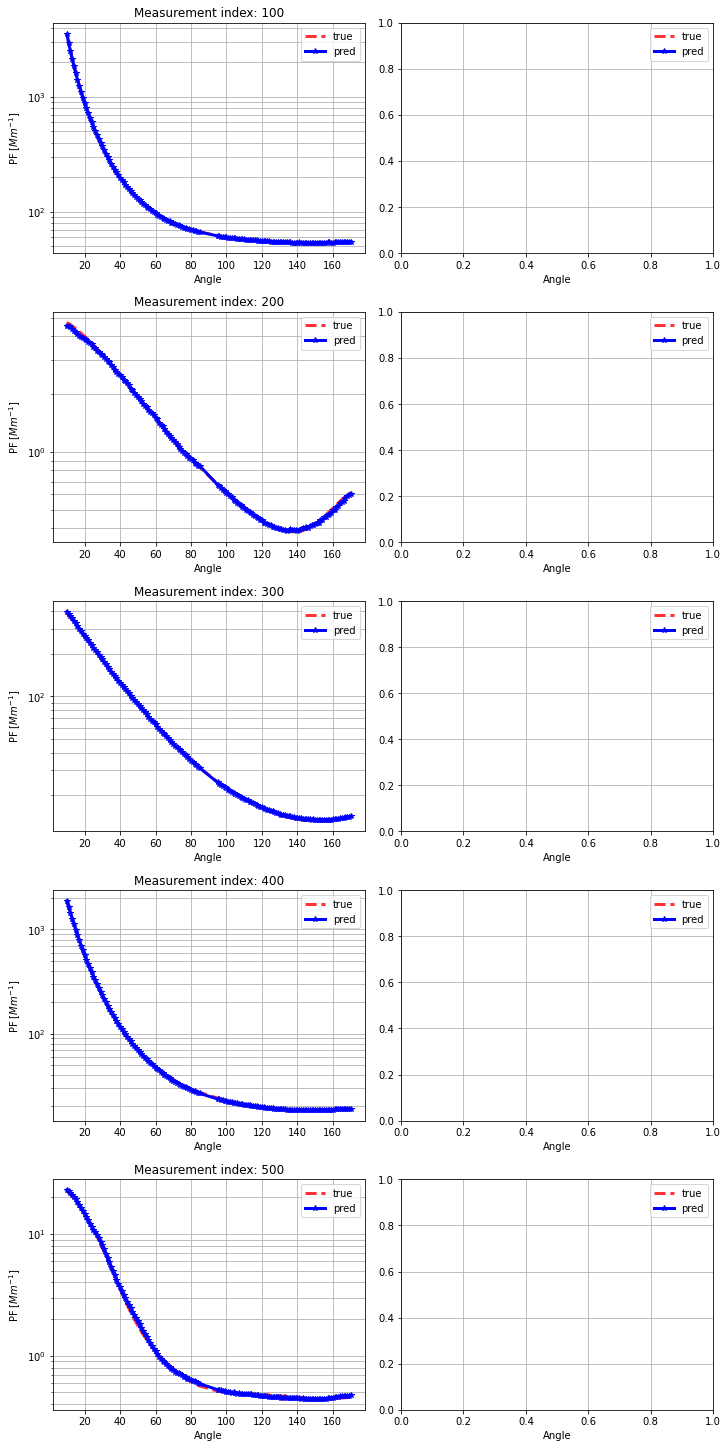

In [59]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(theta, qoi_test[F11_columns].loc[index], ls='--', markersize = 5, lw='3', c='r', alpha=0.8, label='true')
 #   pms_hdf_plot, = axs[nr,1].plot(theta, qoi_test[PPF_columns].loc[index], ls='--', lw='3', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(theta, qoi_pred[F11_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
 #   meas_hdf_plot, = axs[nr,1].plot(theta, qoi_pred[PPF_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
  #  axs[nr,1].set_ylabel('PPF [-]')
  #  axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')